In [48]:
import csv
import numpy as np
import os
np.random.seed(42)
import random
random.seed(42)

In [49]:
# user defined functions
def popTrim(testset, movieFreq):
    return [x for x in testset if movieFreq[int(x[1])] > 2]

def unpopTrim(testset, movieFreq):
    return [x for x in testset if movieFreq[int(x[1])] <= 2]

def highVarTrim(testset, movieFreq, movieVar):
    return [x for x in testset 
            if movieVar[int(x[1])] >= 2 and movieFreq[int(x[1])] >= 5]

def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)


# 3 MovieLens dataset

### loading the user_id and ratings

In [50]:
file_path_ratings = os.path.expanduser('ml-latest-small/ratings.csv')
file_path_movies = os.path.expanduser('ml-latest-small/movies.csv')

user_id = []
movie_id = []
ratings = []

# loading the user_id and ratings
with open(file_path_ratings) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        user_id.append(int(row['userId']))
        movie_id.append(int(row['movieId']))
        ratings.append(float(row['rating']))

## Question 1

In [51]:
user_number = len(np.unique(user_id))
movie_number = len(np.unique(movie_id))
movie_list = dict()
movie_id_u=[]
movie_idx = 0
for id in movie_id:
    if id not in movie_id_u:
        movie_list[id]=int(movie_idx)
        movie_id_u.append(id)
        movie_idx += 1

In [52]:
# movie_list=np.zeros(max(movie_id)+1)
# movie_number=0
# user_number=0
# user_id_u=[]
# for id in user_id:
#     if id not in user_id_u:
#         user_id_u.append(id)
#         user_number=user_number+1
# movie_id_u=[]
# for id in movie_id:
#     if id not in movie_id_u:
#         movie_list[id]=int(movie_number)
#         movie_id_u.append(id)
#         movie_number=movie_number+1
print('number of user=',user_number)
print('number of rated movie=',movie_number)
total_available_rating=len(user_id)
total_possible_rating=user_number*movie_number
print('Sparsity=',float(total_available_rating) / total_possible_rating)

number of user= 610
number of rated movie= 9724
Sparsity= 0.016999683055613623


In [53]:
R = np.zeros((user_number, movie_number))  
W = np.zeros((user_number, movie_number))
for i in range(len(user_id)):
    x = user_id[i] - 1
    y =  int(movie_list[movie_id[i]])
    R[x,y] = ratings[i]
    W[x,y]=1

In [54]:
# np.sum(R,axis=0)
# sss=np.sum(W,axis=0)
# rating=np.sum(R,axis=0)/np.sum(W,axis=0)
# for i in range(movie_number):
#     if sss[i]<200:
#         rating[i]=5 
# movie_id_u[np.argmin(rating)]

## Question 2

rating =  [0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
counts =  [ 1370  2811  1791  7551  5550 20047 13136 26818  8551 13211]


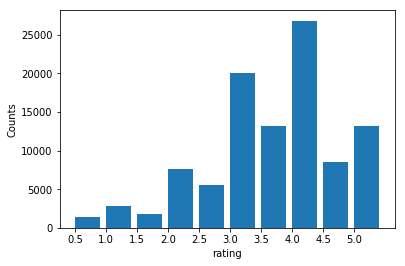

In [55]:
import matplotlib.pyplot as plt
rating_bins, ratingFreq = np.unique(np.sort(R), return_counts=True)
print('rating = ', rating_bins[1:])
print('counts = ', ratingFreq[1:])
plt.bar(rating_bins[1:], ratingFreq[1:], 
        width = 0.4, tick_label = rating_bins[1:], align = 'edge')
# plt.title("Distribution of frequency of the rating values")
plt.xlabel('rating')
plt.ylabel('Counts')
plt.show()

## Question 3

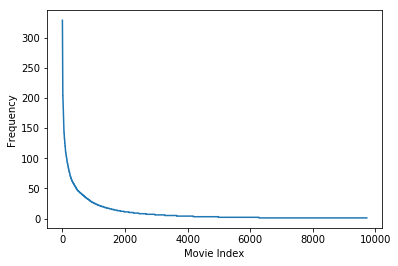

In [56]:
movieFreq = np.sum(R != 0, axis = 0)
movieFreq_dict = {m: movieFreq[movie_list[m]] for m in movie_list.keys()}
plt.plot(np.sort(movieFreq)[::-1])
# plt.title("Distribution of ratings among movies")
plt.xlabel('Movie Index')
plt.ylabel('Frequency')
plt.show()

## Question 4

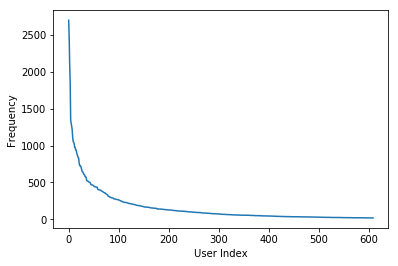

In [57]:
userFreq = np.sum(R != 0 , axis = 1)
plt.plot(np.sort(userFreq)[::-1])
# plt.title("Distribution of ratings among users")
plt.xlabel('User Index')
plt.ylabel('Frequency')
plt.show()

## Question 6

variance =  [0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5.  5.5]
counts =  [5996 2313  990  265  100   22   27    4    4    1    2]


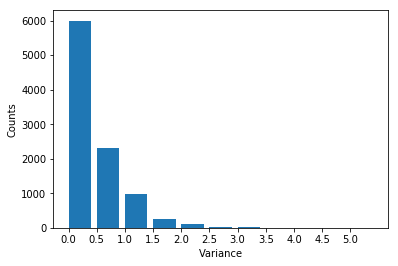

In [58]:
movieVar = [np.var([e for e in row if e != 0]) for row in np.transpose(R)]
movieVar_dict = {m: movieVar[movie_list[m]] for m in movie_list.keys()}
movieVar_bins = np.arange(0, np.max(movieVar) + 0.5, 0.5)
movieVar_height, _ = np.histogram(movieVar, movieVar_bins)
print('variance = ', movieVar_bins)
print('counts = ', movieVar_height)
plt.bar(movieVar_bins[:-1], movieVar_height,
        tick_label = movieVar_bins[:-1], width = 0.4, align = 'edge')
# plt.title("Distribution of variance of the rating values for each moive")
plt.xlabel('Variance')
plt.ylabel('Counts')
plt.show()

# 4 Neighborhood-based collaborative filtering

## Question 10

In [59]:
# Loading data with built-in functions from surprise
from surprise.model_selection import cross_validate
from surprise import KNNWithMeans
from surprise import Reader, Dataset
from surprise.model_selection import KFold
from surprise import accuracy
reader = Reader(line_format='user item rating timestamp', sep=',', skip_lines=1)
data = Dataset.load_from_file('ml-latest-small/ratings.csv', reader)


In [60]:
# define a cross-validation iterator
kf = KFold(n_splits=10)
kValues = range(2, 102, 2)

In [61]:
RMSEs10 = []; MAEs10 = []
for k in kValues:
    print('k = ', k)
    algo = KNNWithMeans(k=k, sim_options={'name': 'pearson', 'user_based': True})
    rmse_kf = []; mae_kf = []
    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        predictions = algo.test(testset)
        rmse_kf.append(accuracy.rmse(predictions, verbose=False))
        mae_kf.append(accuracy.mae(predictions, verbose=False))
    RMSEs10.append(np.mean(rmse_kf))
    MAEs10.append(np.mean(mae_kf))

k =  2
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
k =  4
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing simi

Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
k =  24
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity m

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
k =  46
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity

Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
k =  66
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity m

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
k =  88
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity

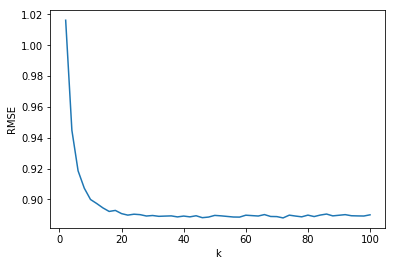

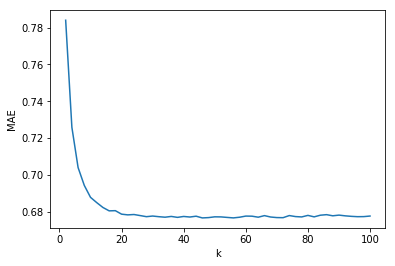

In [62]:
plt.plot(kValues, RMSEs10)
# plt.title("Average RMSE with 10-fold cross validation")
plt.xlabel('k')
plt.ylabel('RMSE')
plt.show()

plt.plot(kValues, MAEs10)
# plt.title("Average MAE with 10-fold cross validation")
plt.xlabel('k')
plt.ylabel('MAE')
plt.show()

## Question 11

In [63]:
for idx in range(len(kValues)):
    print('k =', kValues[idx], '  RMSE =', RMSEs10[idx], '  MAE =', MAEs10[idx])

k = 2   RMSE = 1.0162014435317746   MAE = 0.7839689816510724
k = 4   RMSE = 0.9448816093685493   MAE = 0.725837902308
k = 6   RMSE = 0.9185502219725906   MAE = 0.7039564630665325
k = 8   RMSE = 0.9072998847422064   MAE = 0.6942547698139385
k = 10   RMSE = 0.8999792211274047   MAE = 0.6877810243658387
k = 12   RMSE = 0.897365963069174   MAE = 0.6849219818083256
k = 14   RMSE = 0.8945264848442331   MAE = 0.6822746840667484
k = 16   RMSE = 0.8922414042791033   MAE = 0.6804485917696319
k = 18   RMSE = 0.8928989309151172   MAE = 0.6805430060604903
k = 20   RMSE = 0.8908225769885071   MAE = 0.67864720934731
k = 22   RMSE = 0.889850186754213   MAE = 0.6782630546138348
k = 24   RMSE = 0.8904502936034906   MAE = 0.6784555820640088
k = 26   RMSE = 0.8901458597250496   MAE = 0.6778760255152869
k = 28   RMSE = 0.8892722775046907   MAE = 0.6772828282009943
k = 30   RMSE = 0.8896039873954198   MAE = 0.6776272957658482
k = 32   RMSE = 0.8890720852105224   MAE = 0.6772745179999481
k = 34   RMSE = 0.88

In [64]:
k_best = 22

In [65]:
RMSEs12 = []; MAEs12 = []
RMSEs13 = []; MAEs13 = []
RMSEs14 = []; MAEs14 = []
for k in kValues:
    print('k = ', k)
    algo = KNNWithMeans(k=k, sim_options={'name': 'pearson', 'user_based': True})
    rmse_1 = []; mae_1 = []
    rmse_2 = []; mae_2 = []
    rmse_3 = []; mae_3 = []
    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        
        prediction1 = algo.test(popTrim(testset, movieFreq_dict))
        prediction2 = algo.test(unpopTrim(testset, movieFreq_dict))
        prediction3 = algo.test(highVarTrim(testset, movieFreq_dict, movieVar_dict))
        
        rmse_1.append(accuracy.rmse(prediction1, verbose=False))
        mae_1.append(accuracy.mae(prediction1, verbose=False))
        rmse_2.append(accuracy.rmse(prediction2, verbose=False))
        mae_2.append(accuracy.mae(prediction2, verbose=False))
        rmse_3.append(accuracy.rmse(prediction3, verbose=False))
        mae_3.append(accuracy.mae(prediction3, verbose=False))
        
    RMSEs12.append(np.mean(rmse_1))
    MAEs12.append(np.mean(mae_1))
    RMSEs13.append(np.mean(rmse_2))
    MAEs13.append(np.mean(mae_2))
    RMSEs14.append(np.mean(rmse_3))
    MAEs14.append(np.mean(mae_3))

k =  2
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
k =  4
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing simi

Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
k =  24
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity m

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
k =  46
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity

Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
k =  66
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity m

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
k =  88
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity

## Question 12

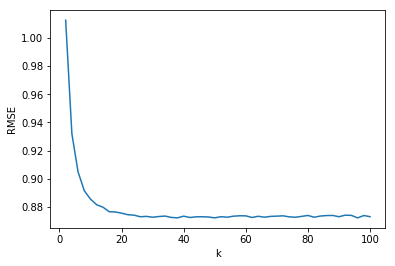

In [66]:
plt.plot(kValues, RMSEs12)
# plt.title("Average RMSE with popular movie trimming")
plt.xlabel('k')
plt.ylabel('RMSE')
plt.show()

# plt.plot(kValues, MAEs12)
# plt.title("Average MAE with popular movie trimming")
# plt.xlabel('k')
# plt.ylabel('MAE')
# plt.show()

k = 22<br>
RMSE = 0.889850186754213

In [82]:
for idx in range(len(kValues)):
    print('k =', kValues[idx], '  RMSE =', RMSEs10[idx], '  MAE =', MAEs12[idx])

k = 2   RMSE = 1.0162014435317746   MAE = 0.7820871732281637
k = 4   RMSE = 0.9448816093685493   MAE = 0.716977699033255
k = 6   RMSE = 0.9185502219725906   MAE = 0.6946141569058704
k = 8   RMSE = 0.9072998847422064   MAE = 0.6826094194436811
k = 10   RMSE = 0.8999792211274047   MAE = 0.6771902109359937
k = 12   RMSE = 0.897365963069174   MAE = 0.6739257851031418
k = 14   RMSE = 0.8945264848442331   MAE = 0.6711159640809972
k = 16   RMSE = 0.8922414042791033   MAE = 0.6690313175548005
k = 18   RMSE = 0.8928989309151172   MAE = 0.6690534882016059
k = 20   RMSE = 0.8908225769885071   MAE = 0.6683384884264887
k = 22   RMSE = 0.889850186754213   MAE = 0.666955117799388
k = 24   RMSE = 0.8904502936034906   MAE = 0.6667785125638294
k = 26   RMSE = 0.8901458597250496   MAE = 0.6659063707023505
k = 28   RMSE = 0.8892722775046907   MAE = 0.6655868445666012
k = 30   RMSE = 0.8896039873954198   MAE = 0.6649665648519704
k = 32   RMSE = 0.8890720852105224   MAE = 0.6656062589454299
k = 34   RMSE = 

## Question 13

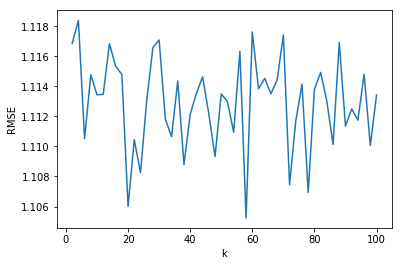

In [67]:
plt.plot(kValues, RMSEs13)
# plt.title("Average RMSE with unpopular movie trimming")
plt.xlabel('k')
plt.ylabel('RMSE')
plt.show()

# plt.plot(kValues, MAEs13)
# plt.title("Average MAE with unpopular movie trimming")
# plt.xlabel('k')
# plt.ylabel('MAE')
# plt.show()

In [78]:
min(RMSEs13)

1.105243349024755

In [79]:
kValues[np.argmin(RMSEs13)]

58

## Question 14

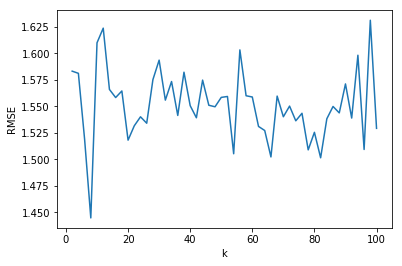

In [68]:
plt.plot(kValues, RMSEs14)
# plt.title("Average RMSE with high variance movie trimming")
plt.xlabel('k')
plt.ylabel('RMSE')
plt.show()

# plt.plot(kValues, MAEs14)
# plt.title("Average MAE with high variance movie trimming")
# plt.xlabel('k')
# plt.ylabel('MAE')
# plt.show()

In [80]:
min(RMSEs14)

1.4446760070324243

In [81]:
kValues[np.argmin(RMSEs14)]

8

## Question 15

In [69]:
from surprise.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
# train the model with best k
trainset, testset = train_test_split(data, test_size=0.1)
algo = KNNWithMeans(k=k_best, sim_options={'name': 'pearson', 'user_based': True})
algo.fit(trainset)
prediction4 = algo.test(testset)
# for pred in prediction4:
#     print(pred[2], pred[3])

Computing the pearson similarity matrix...
Done computing similarity matrix.


threshold =  2.5


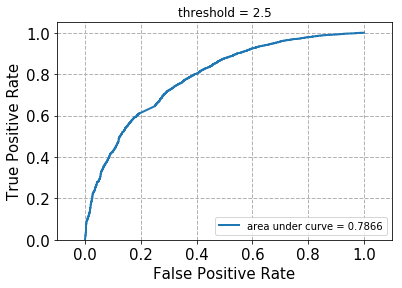

threshold =  3


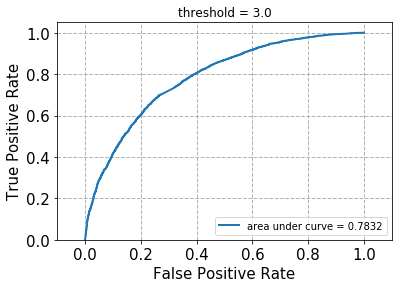

threshold =  3.5


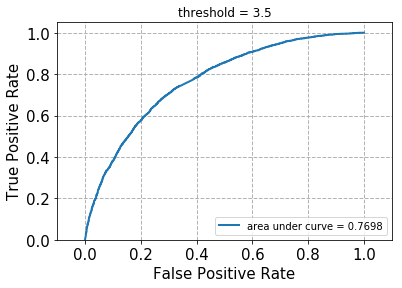

threshold =  4


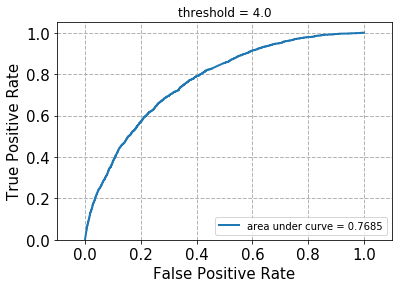

In [70]:
thresholds = [2.5, 3, 3.5, 4]
for t in thresholds:
    print('threshold = ', t)
    y = [1 if pred[2] > t else 0 for pred in prediction4]
    scores = [pred[3] for pred in prediction4]
    fpr, tpr, _ = roc_curve(y, scores)
    plot_roc(fpr, tpr)
    plt.title('threshold = %.1f' % t)
    plt.show()